# //**Lab 04: Object Tracking trên Google Colab**//


## 1. Thiết lập môi trường

In [1]:
# Cập nhật pip
# Khai báo thư viện
# Framework: PyTorch
!pip install --quiet --upgrade pip
!pip install --quiet ultralytics opencv-python-headless numpy pandas scipy filterpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'filterpy' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'filterpy'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [2]:
import cv2, numpy, sklearn, torch

print("OpenCV:", cv2.__version__)
print("NumPy:", numpy.__version__)
print("scikit-learn:", sklearn.__version__)
print("PyTorch:", torch.__version__, "CUDA:", torch.cuda.is_available())


OpenCV: 4.12.0
NumPy: 2.0.2
scikit-learn: 1.6.1
PyTorch: 2.8.0+cu126 CUDA: True


## 2. Tải và phân tích dữ liệu

### 2.1 Tải dữ liệu

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/MOT17.zip

Streaming output truncated to the last 5000 lines.
  inflating: MOT17/train/MOT17-04-DPM/img1/000455.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000333.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/001039.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000327.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000441.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000496.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000482.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000509.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000521.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000247.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000253.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000535.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000284.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000290.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000079.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000045.jpg  
  inflating: MOT17/train/MOT17-04-DPM/img1/000723.jpg

### 2.2 Phân tích dữ liệu

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from IPython.display import Video
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
import imageio

In [6]:
PATH=[]
for dirname, _, filenames in os.walk('/content/MOT17'):
    paths=[]
    if 'img1' in dirname:
        for filename in filenames:
            if filename[-4:]=='.jpg':
                paths+=[os.path.join(dirname, filename)]
    paths=sorted(paths)
    if len(paths)>10:
        PATH+=[paths]

print(len(PATH))
for i in range(len(PATH)):
    path=PATH[i][0]
    print(i,path.split('/')[-4:-2])

42
0 ['test', 'MOT17-12-SDP']
1 ['test', 'MOT17-01-SDP']
2 ['test', 'MOT17-07-FRCNN']
3 ['test', 'MOT17-12-FRCNN']
4 ['test', 'MOT17-06-DPM']
5 ['test', 'MOT17-08-SDP']
6 ['test', 'MOT17-14-SDP']
7 ['test', 'MOT17-06-FRCNN']
8 ['test', 'MOT17-14-FRCNN']
9 ['test', 'MOT17-03-DPM']
10 ['test', 'MOT17-07-SDP']
11 ['test', 'MOT17-01-FRCNN']
12 ['test', 'MOT17-12-DPM']
13 ['test', 'MOT17-03-SDP']
14 ['test', 'MOT17-14-DPM']
15 ['test', 'MOT17-03-FRCNN']
16 ['test', 'MOT17-01-DPM']
17 ['test', 'MOT17-08-FRCNN']
18 ['test', 'MOT17-07-DPM']
19 ['test', 'MOT17-06-SDP']
20 ['test', 'MOT17-08-DPM']
21 ['train', 'MOT17-11-FRCNN']
22 ['train', 'MOT17-09-SDP']
23 ['train', 'MOT17-02-FRCNN']
24 ['train', 'MOT17-04-SDP']
25 ['train', 'MOT17-04-DPM']
26 ['train', 'MOT17-02-SDP']
27 ['train', 'MOT17-05-SDP']
28 ['train', 'MOT17-11-SDP']
29 ['train', 'MOT17-04-FRCNN']
30 ['train', 'MOT17-05-FRCNN']
31 ['train', 'MOT17-02-DPM']
32 ['train', 'MOT17-11-DPM']
33 ['train', 'MOT17-13-FRCNN']
34 ['train', 'MOT1

In [7]:
import os

def explore_mot17(root_dir):
    """
    Hàm duyệt qua dataset MOT17 để xem cấu trúc thư mục và file.
    root_dir: đường dẫn đến thư mục MOT17 (chứa MOT17/train, MOT17/test)
    """
    for split in ["train", "test"]:
        split_path = os.path.join(root_dir, split)
        if not os.path.exists(split_path):
            continue
        print(f"\n=== {split.upper()} SET ===")
        for seq in sorted(os.listdir(split_path)):
            seq_path = os.path.join(split_path, seq)
            if not os.path.isdir(seq_path):
                continue
            print(f"\nSequence: {seq}")
            # Kiểm tra các thư mục con
            for sub in ["img1", "det", "gt"]:
                sub_path = os.path.join(seq_path, sub)
                if os.path.exists(sub_path):
                    files = os.listdir(sub_path)
                    print(f"  ├── {sub}/ ({len(files)} files)")
                    if files:
                        print(f"  │    ├── Example file: {files[0]}")
                else:
                    print(f"  ├── {sub}/ (not found)")

            # Kiểm tra file seqinfo.ini
            seqinfo = os.path.join(seq_path, "seqinfo.ini")
            if os.path.exists(seqinfo):
                print("  ├── seqinfo.ini (available)")

# Ví dụ: thay đường dẫn này thành nơi bạn lưu dataset MOT17
explore_mot17('/content/MOT17')



=== TRAIN SET ===

Sequence: MOT17-02-DPM
  ├── img1/ (600 files)
  │    ├── Example file: 000491.jpg
  ├── det/ (1 files)
  │    ├── Example file: det.txt
  ├── gt/ (1 files)
  │    ├── Example file: gt.txt
  ├── seqinfo.ini (available)

Sequence: MOT17-02-FRCNN
  ├── img1/ (600 files)
  │    ├── Example file: 000491.jpg
  ├── det/ (1 files)
  │    ├── Example file: det.txt
  ├── gt/ (1 files)
  │    ├── Example file: gt.txt
  ├── seqinfo.ini (available)

Sequence: MOT17-02-SDP
  ├── img1/ (600 files)
  │    ├── Example file: 000491.jpg
  ├── det/ (1 files)
  │    ├── Example file: det.txt
  ├── gt/ (1 files)
  │    ├── Example file: gt.txt
  ├── seqinfo.ini (available)

Sequence: MOT17-04-DPM
  ├── img1/ (1050 files)
  │    ├── Example file: 000491.jpg
  ├── det/ (1 files)
  │    ├── Example file: det.txt
  ├── gt/ (1 files)
  │    ├── Example file: gt.txt
  ├── seqinfo.ini (available)

Sequence: MOT17-04-FRCNN
  ├── img1/ (1050 files)
  │    ├── Example file: 000491.jpg
  ├── det/ 

In [8]:
gttxt_path='/content/MOT17/train/MOT17-02-DPM/gt/gt.txt'

with open(gttxt_path) as f:
    gt = f.readlines()
gtar=np.array(gt)
box=[]
for i in range(len(gtar)):
    txt=gtar[i].replace('\n','')
    box+=[txt.split(',')]
print(box[0:2])
BOX=pd.DataFrame(columns=range(9),data=box)
BOX.iloc[:,0:8]=BOX.iloc[:,0:8].astype(int)
BOX.iloc[:,8]=BOX.iloc[:,8].astype(float)
display(BOX)

[['1', '1', '912', '484', '97', '109', '0', '7', '1'], ['2', '1', '912', '484', '97', '109', '0', '7', '1']]


,0,1,2,3,4,5,6,7,8
0,1,1,912,484,97,109,0,7,1.0
1,2,1,912,484,97,109,0,7,1.0
2,3,1,912,484,97,109,0,7,1.0
3,4,1,912,484,97,109,0,7,1.0
4,5,1,912,484,97,109,0,7,1.0
...,...,...,...,...,...,...,...,...,...
29998,593,80,1043,445,32,97,1,1,0.0
29999,594,80,1043,445,32,97,1,1,0.0
30000,600,81,1007,451,24,69,1,1,0.0
30001,600,82,987,473,21,43,1,1,0.0


In [9]:
class_map = {0: u'__background__', 1: u'person', 2: u'bicycle',3: u'car', 4: u'motorcycle',
             5: u'airplane', 6: u'bus', 7: u'train', 8: u'truck', 9: u'boat', 10: u'traffic light',
             11: u'fire hydrant', 12: u'stop sign', 13: u'parking meter', 14: u'bench', 15: u'bird',
             16: u'cat', 17: u'dog', 18: u'horse', 19: u'sheep', 20: u'cow', 21: u'elephant',
             22: u'bear', 23: u'zebra', 24: u'giraffe', 25: u'backpack', 26: u'umbrella', 27: u'handbag',
             28: u'tie', 29: u'suitcase', 30: u'frisbee', 31: u'skis', 32: u'snowboard', 33: u'sports ball',
             34: u'kite', 35: u'baseball bat', 36: u'baseball glove', 37: u'skateboard', 38: u'surfboard',
             39: u'tennis racket', 40: u'bottle', 41: u'wine glass', 42: u'cup', 43: u'fork', 44: u'knife',
             45: u'spoon', 46: u'bowl', 47: u'banana', 48: u'apple', 49: u'sandwich', 50: u'orange',
             51: u'broccoli', 52: u'carrot', 53: u'hot dog', 54: u'pizza', 55: u'donut', 56: u'cake',
             57: u'chair', 58: u'couch', 59: u'potted plant', 60: u'bed', 61: u'dining table',
             62: u'toilet', 63: u'tv', 64: u'laptop',
             65: u'mouse', 66: u'remote', 67: u'keyboard', 68: u'cell phone', 69: u'microwave',
             70: u'oven', 71: u'toaster', 72: u'sink', 73: u'refrigerator', 74: u'book', 75: u'clock',
             76: u'vase', 77: u'scissors', 78: u'teddy bear', 79: u'hair drier', 80: u'toothbrush'}

,0,1,2,3,4,5,6,7,8
8891,320,19,1050,400,194,609,1,1,1.0
9881,320,23,896,421,144,525,1,1,1.0
11667,320,26,381,464,43,110,1,1,1.0
12237,320,27,490,455,46,108,1,1,1.0
14720,320,32,24,405,277,448,1,1,1.0
16064,320,36,821,441,75,217,1,1,0.98684
16610,320,38,1233,427,101,258,1,1,0.88235
17210,320,39,1434,439,45,110,1,1,1.0
18728,320,43,632,459,22,63,1,1,1.0
24667,320,57,580,460,21,58,1,1,1.0


12


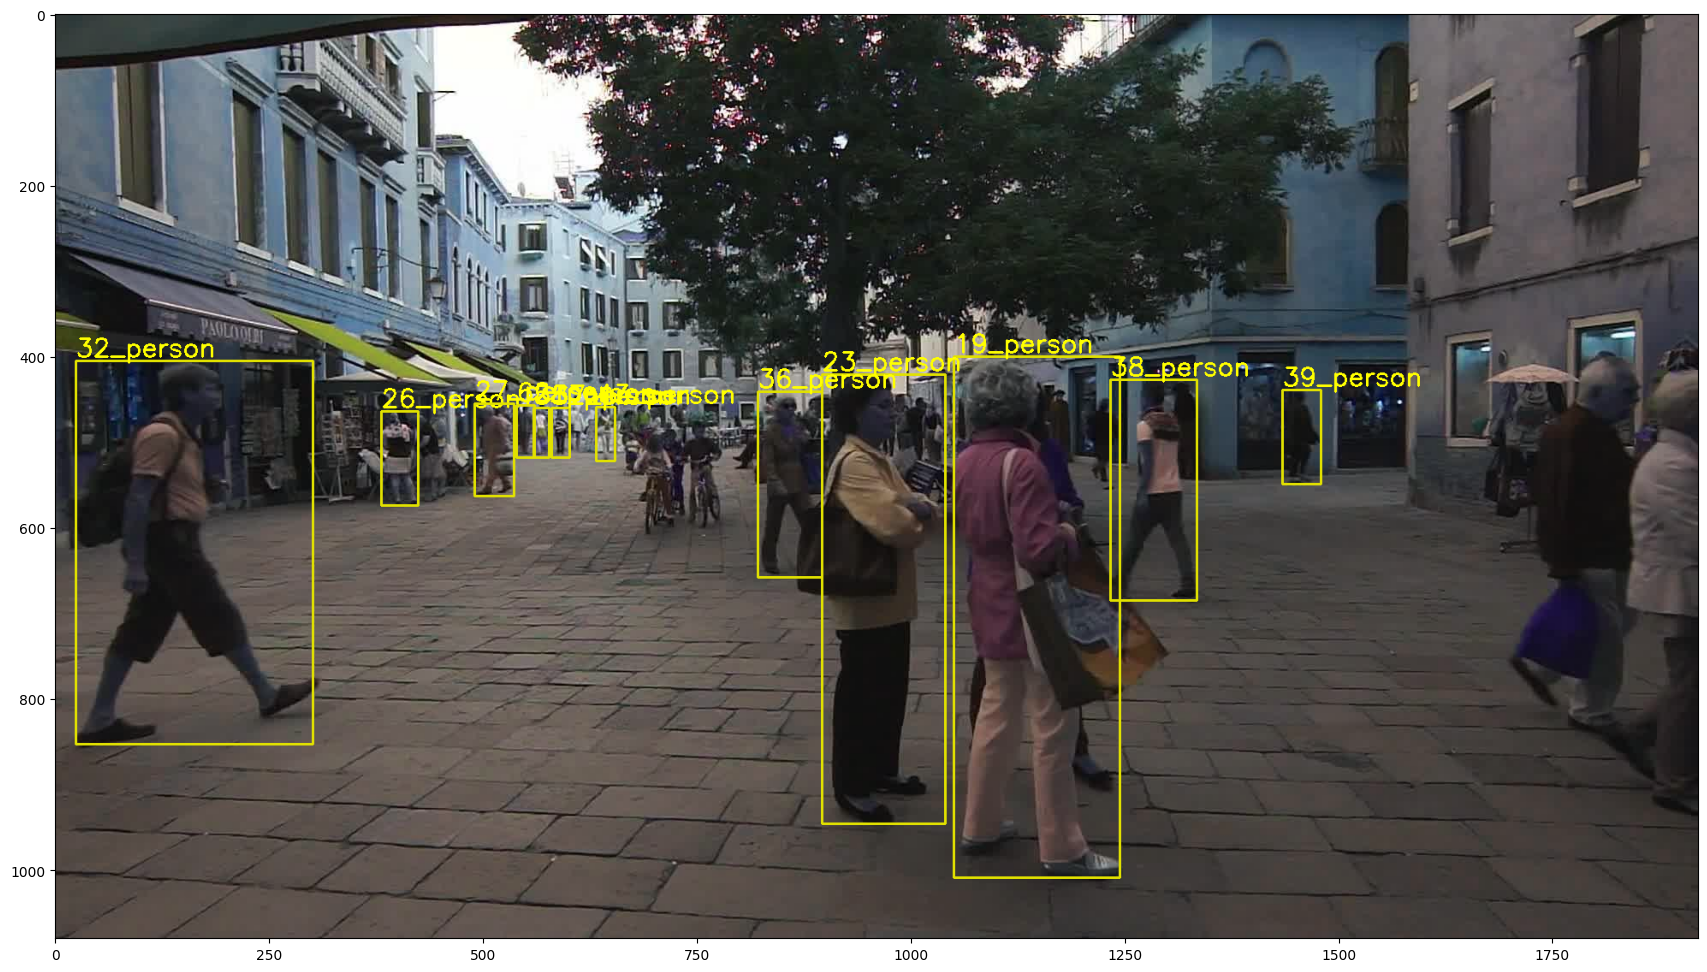

In [10]:
image = cv2.imread("/content/MOT17/train/MOT17-02-DPM/img1/000320.jpg")

boxi=BOX[(BOX[0]==320) & (BOX[8]>0.8) & (BOX[7]==1)]
display(boxi)
print(len(boxi))

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255,255,0)
thickness = 2

for i in range(len(boxi)):
    row=boxi.iloc[i].tolist()
    [idi,x,y,w,h,b,c]=row[1:8]
    cv2.rectangle(image,(x,y),(x+w, y+h),(225,225,0),2)
    cv2.putText(image, str(idi)+'_'+class_map[c], (x,y-5), font, font_scale, font_color, thickness)

plt.figure(figsize=(24,12))
plt.imshow(image)
plt.show()

## 3. Thuật toán SORT


### 3.0. Import

In [11]:
import os, glob, math, configparser, time
import numpy as np
import pandas as pd
import cv2
from filterpy.kalman import KalmanFilter
from scipy.optimize import linear_sum_assignment
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


### 3.1. Đường dẫn & tiện ích đọc dữ liệu MOT

In [12]:
# ===== CẦN CHỈNH CHÍNH XÁC ĐƯỜNG DẪN NÀY =====
SEQ_ROOT = "/content/MOT17/train/MOT17-02-FRCNN"   # ví dụ
OUTPUT_VIDEO = "/content/output_sort_yolov8.mp4"
OUTPUT_TRACKS_TXT = "/content/tracks_yolov8_sort.txt"   # (tuỳ chọn) theo format MOTChallenge

# Tham số YOLO & SORT & EVAL
YOLO_MODEL = "yolov8s.pt"     # có thể đổi: yolov8n.pt (nhanh), yolov8m.pt (chính xác hơn)
YOLO_CONF = 0.25              # ngưỡng confidence của YOLO
YOLO_IMG = 640                # kích thước ảnh khi inference
ASSOC_IOU_THRESHOLD = 0.3     # ngưỡng IoU để gán trong SORT
EVAL_IOU_THRESHOLD = 0.5      # ngưỡng IoU khi đánh giá (match GT-Track)

In [13]:
def read_seqinfo(seq_root):
    ini_path = os.path.join(seq_root, "seqinfo.ini")
    info = {"frameRate": 30, "imWidth": 0, "imHeight": 0, "imDir": "img1"}
    if os.path.exists(ini_path):
        cfg = configparser.ConfigParser()
        cfg.read(ini_path)
        s = cfg["Sequence"]
        info["frameRate"] = int(float(s.get("frameRate", 30)))
        info["imWidth"] = int(s.get("imWidth", "0"))
        info["imHeight"] = int(s.get("imHeight", "0"))
        info["imDir"] = s.get("imDir", "img1")
    return info

def load_image_list(seq_root, imdir="img1"):
    img_dir = os.path.join(seq_root, imdir)
    files = glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.png"))
    assert len(files) > 0, f"Không có ảnh trong {img_dir}"
    files = sorted(files, key=lambda p: int(os.path.splitext(os.path.basename(p))[0]))
    return files

def load_gt(seq_root):
    gt_file = os.path.join(seq_root, "gt", "gt.txt")
    cols = ["frame","id","bb_left","bb_top","bb_width","bb_height","conf","class","vis"]
    gt = pd.read_csv(gt_file, header=None, names=cols)
    # Chuẩn MOT: chỉ tính người class==1 và conf==1
    gt = gt[(gt["class"]==1) & (gt["conf"]==1)].copy()
    return gt

def xywh_to_x1y1x2y2(x, y, w, h):
    return x, y, x+w, y+h

def iou(boxA, boxB):
    xx1 = max(boxA[0], boxB[0]); yy1 = max(boxA[1], boxB[1])
    xx2 = min(boxA[2], boxB[2]); yy2 = min(boxA[3], boxB[3])
    w = max(0.0, xx2-xx1); h = max(0.0, yy2-yy1)
    inter = w*h
    a = max(0.0, (boxA[2]-boxA[0])) * max(0.0, (boxA[3]-boxA[1]))
    b = max(0.0, (boxB[2]-boxB[0])) * max(0.0, (boxB[3]-boxB[1]))
    return inter / (a + b - inter + 1e-12)

### 3.2. Phần SORT chính

In [14]:
def convert_bbox_to_z(bbox):
    # [x1,y1,x2,y2] -> [x,y,s,r]
    w = bbox[2] - bbox[0]; h = bbox[3] - bbox[1]
    x = bbox[0] + w/2.0; y = bbox[1] + h/2.0
    s = w*h; r = w / (h + 1e-12)
    return np.array([x, y, s, r]).reshape((4,1))

def convert_x_to_bbox(x):
    # state -> [x1,y1,x2,y2]
    w = math.sqrt(max(0.0, x[2]*x[3])); h = x[2] / (w + 1e-12)
    x1 = x[0] - w/2.0; y1 = x[1] - h/2.0
    x2 = x[0] + w/2.0; y2 = x[1] + h/2.0
    return np.array([x1, y1, x2, y2]).reshape((1,4))

class KalmanBoxTracker:
    count = 0
    def __init__(self, bbox):
        self.kf = KalmanFilter(dim_x=7, dim_z=4)
        self.kf.F = np.array([
            [1,0,0,0,1,0,0],
            [0,1,0,0,0,1,0],
            [0,0,1,0,0,0,1],
            [0,0,0,1,0,0,0],
            [0,0,0,0,1,0,0],
            [0,0,0,0,0,1,0],
            [0,0,0,0,0,0,1]], dtype=float)
        self.kf.H = np.array([
            [1,0,0,0,0,0,0],
            [0,1,0,0,0,0,0],
            [0,0,1,0,0,0,0],
            [0,0,0,1,0,0,0]], dtype=float)
        self.kf.R[2:,2:] *= 10.0
        self.kf.P[4:,4:] *= 1000.0
        self.kf.P *= 10.0
        self.kf.Q[-1,-1] *= 0.01
        self.kf.Q[4:,4:] *= 0.01

        self.kf.x[:4] = convert_bbox_to_z(bbox)
        self.time_since_update = 0
        self.id = KalmanBoxTracker.count; KalmanBoxTracker.count += 1
        self.history = []
        self.hits = 0; self.hit_streak = 0; self.age = 0

    def update(self, bbox):
        self.time_since_update = 0; self.history = []
        self.hits += 1; self.hit_streak += 1
        self.kf.update(convert_bbox_to_z(bbox))

    def predict(self):
        if (self.kf.x[6] + self.kf.x[2]) <= 0: self.kf.x[6] *= 0.0
        self.kf.predict(); self.age += 1
        if self.time_since_update > 0: self.hit_streak = 0
        self.time_since_update += 1
        self.history.append(convert_x_to_bbox(self.kf.x))
        return self.history[-1]

    def get_state(self):
        return convert_x_to_bbox(self.kf.x)

def associate_detections_to_trackers(dets, trks, iou_threshold=0.3):
    if len(trks)==0:
        return np.empty((0,2), dtype=int), np.arange(len(dets)), np.empty((0), dtype=int)

    iou_matrix = np.zeros((len(dets), len(trks)), dtype=float)
    for d, det in enumerate(dets):
        for t, trk in enumerate(trks):
            iou_matrix[d, t] = iou(det, trk)

    row_ind, col_ind = linear_sum_assignment(-iou_matrix)  # maximize IoU
    matched_indices = np.array(list(zip(row_ind, col_ind)), dtype=int) if len(row_ind) else np.empty((0,2), int)

    unmatched_dets = [d for d in range(len(dets)) if d not in matched_indices[:,0]] if matched_indices.size else list(range(len(dets)))
    unmatched_trks = [t for t in range(len(trks)) if t not in matched_indices[:,1]] if matched_indices.size else list(range(len(trks)))

    matches = []
    for m in matched_indices:
        if iou_matrix[m[0], m[1]] < iou_threshold:
            unmatched_dets.append(m[0]); unmatched_trks.append(m[1])
        else:
            matches.append(m.reshape(1,2))
    matches = np.concatenate(matches, axis=0) if len(matches) else np.empty((0,2), dtype=int)
    return matches, np.array(unmatched_dets, int), np.array(unmatched_trks, int)

class Sort:
    def __init__(self, max_age=30, min_hits=3, iou_threshold=0.3):
        self.max_age = max_age; self.min_hits = min_hits; self.iou_threshold = iou_threshold
        self.trackers = []; self.frame_count = 0

    def update(self, dets=np.empty((0,5))):
        self.frame_count += 1
        trks = np.zeros((len(self.trackers), 4), dtype=float)
        to_del = []
        for t, trk in enumerate(self.trackers):
            pos = trk.predict()[0]; trks[t, :] = pos
            if np.any(np.isnan(pos)): to_del.append(t)
        for t in reversed(to_del): self.trackers.pop(t)

        dets_xyxy = dets[:, :4] if len(dets)>0 else np.empty((0,4), float)
        matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets_xyxy, trks, self.iou_threshold)

        for m in matched: self.trackers[m[1]].update(dets_xyxy[m[0], :])
        for i in unmatched_dets:
            trk = KalmanBoxTracker(dets_xyxy[i, :]); self.trackers.append(trk)

        ret = []
        i = len(self.trackers)
        for trk in reversed(self.trackers):
            d = trk.get_state()[0]
            if (trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits):
                ret.append(np.concatenate((d, [trk.id + 1])).reshape(1, -1))
            i -= 1
            if trk.time_since_update > self.max_age: self.trackers.pop(i)

        return np.concatenate(ret) if len(ret) else np.empty((0,5), float)


### 3.3. Chuẩn bị detection theo frame và vẽ kết quả





In [15]:
# Khởi tạo model YOLO (COCO pretrained)
yolo_model = YOLO(YOLO_MODEL)

def detect_person_yolov8(frame, conf=YOLO_CONF, imgz=YOLO_IMG):
    """
    Trả về Nx5 = [x1, y1, x2, y2, score] chỉ cho class 'person' (COCO id=0).
    """
    res = yolo_model.predict(frame, conf=conf, imgsz=imgz, verbose=False)[0]
    out = []
    for b in res.boxes:
        cls = int(b.cls)
        if cls != 0:  # chỉ lấy người
            continue
        x1, y1, x2, y2 = b.xyxy[0].tolist()
        sc = float(b.conf)
        out.append([x1, y1, x2, y2, sc])
    return np.array(out, dtype=float) if len(out) else np.empty((0,5), dtype=float)

def draw_tracks(frame, tracks):
    for t in tracks:
        x1, y1, x2, y2, tid = [int(v) for v in t]
        cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
        cv2.putText(frame, f"ID {tid}", (x1, max(0, y1-7)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    return frame


## 4. Trực quan hóa bằng video

In [16]:
# Đọc danh sách ảnh + FPS + GT
seqinfo = read_seqinfo(SEQ_ROOT)
img_files = load_image_list(SEQ_ROOT, seqinfo["imDir"])
fps = seqinfo["frameRate"] if seqinfo["frameRate"] > 0 else 30
gt = load_gt(SEQ_ROOT)

# Writer video
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
sample = cv2.imread(img_files[0])
H, W = sample.shape[:2]
writer = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (W, H))

# Tracker
tracker = Sort(max_age=30, min_hits=3, iou_threshold=ASSOC_IOU_THRESHOLD)

tracker_results = {}     # frame_id -> [[x1,y1,x2,y2,track_id], ...]
mot_format_rows = []     # (tuỳ chọn) lưu ra txt theo chuẩn MOTChallenge

t0 = time.time()
for frame_id, img_path in enumerate(img_files, start=1):
    frame = cv2.imread(img_path)

    # YOLOv8 person detection
    dets = detect_person_yolov8(frame)

    # SORT tracking
    tracks = tracker.update(dets)
    tracker_results[frame_id] = tracks.tolist()

    # (tuỳ chọn) ghi theo format MOT: frame, id, x, y, w, h, conf, -1, -1, -1
    for x1, y1, x2, y2, tid in tracks:
        w = x2 - x1; h = y2 - y1
        mot_format_rows.append([frame_id, int(tid), float(x1), float(y1), float(w), float(h), 1.0, -1, -1, -1])

    # Vẽ & ghi video
    frame_drawn = draw_tracks(frame, tracks)
    writer.write(frame_drawn)

writer.release()
t1 = time.time()
print(f"✅ ĐÃ LƯU VIDEO: {OUTPUT_VIDEO} | Thời gian: {t1 - t0:.2f}s")

# (tuỳ chọn) lưu kết quả theo chuẩn MOT
if len(mot_format_rows):
    df_out = pd.DataFrame(mot_format_rows, columns=["frame","id","bb_left","bb_top","bb_width","bb_height","conf","x","y","z"])
    df_out.to_csv(OUTPUT_TRACKS_TXT, header=False, index=False)
    print("✅ ĐÃ LƯU TRACKS TXT (MOT format):", OUTPUT_TRACKS_TXT)


/tmp/ipython-input-3586829508.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  w = math.sqrt(max(0.0, x[2]*x[3])); h = x[2] / (w + 1e-12)


✅ ĐÃ LƯU VIDEO: /content/output_sort_yolov8.mp4 | Thời gian: 36.39s
✅ ĐÃ LƯU TRACKS TXT (MOT format): /content/tracks_yolov8_sort.txt


## 5. Đánh giá (train set) — MOTA, MOTP, IDS (đơn giản)

In [17]:
def evaluate_mot(gt_df, tracker_results, iou_thr=0.5):
    gt_total = len(gt_df)
    fp = fn = ids = 0
    sum_iou = 0.0
    match_count = 0
    last_match = {}  # track_id -> last gt_id

    # group GT theo frame
    for frame_id, group in gt_df.groupby("frame"):
        # GT boxes: [x1,y1,x2,y2, gt_id]
        gts = []
        for _, r in group.iterrows():
            x1, y1, x2, y2 = xywh_to_x1y1x2y2(r.bb_left, r.bb_top, r.bb_width, r.bb_height)
            gts.append([x1, y1, x2, y2, int(r.id)])
        gts = np.array(gts, dtype=float) if len(gts) else np.empty((0,5), float)

        trks = np.array(tracker_results.get(frame_id, []), dtype=float)  # [x1,y1,x2,y2,tid]

        if len(gts)==0 and len(trks)>0:
            fp += len(trks)
            continue
        if len(gts)>0 and len(trks)==0:
            fn += len(gts)
            continue
        if len(gts)==0 and len(trks)==0:
            continue

        # Hungarian theo IoU
        iou_matrix = np.zeros((len(gts), len(trks)), dtype=float)
        for i, g in enumerate(gts[:, :4]):
            for j, t in enumerate(trks[:, :4]):
                iou_matrix[i, j] = iou(g, t)

        row_ind, col_ind = linear_sum_assignment(-iou_matrix)  # maximize IoU
        matched = []
        unmatched_gt = set(range(len(gts)))
        unmatched_trk = set(range(len(trks)))

        for gi, tj in zip(row_ind, col_ind):
            if iou_matrix[gi, tj] >= iou_thr:
                matched.append((gi, tj))
                unmatched_gt.discard(gi)
                unmatched_trk.discard(tj)

        fp += len(unmatched_trk)
        fn += len(unmatched_gt)

        for gi, tj in matched:
            iou_val = iou_matrix[gi, tj]
            sum_iou += iou_val
            match_count += 1
            gt_id = int(gts[gi, 4]); trk_id = int(trks[tj, 4])
            if trk_id in last_match and last_match[trk_id] != gt_id:
                ids += 1
            last_match[trk_id] = gt_id

    mota = 1.0 - (fp + fn + ids) / max(1, gt_total)
    motp = (sum_iou / match_count) if match_count > 0 else 0.0  # IoU trung bình
    return {"MOTA": mota, "MOTP": motp, "FP": fp, "FN": fn, "IDS": ids, "GT": gt_total, "Matches": match_count}


In [18]:
metrics = evaluate_mot(gt, tracker_results, iou_thr=EVAL_IOU_THRESHOLD)
print("===== KẾT QUẢ HIỆU SUẤT (YOLOv8 + SORT) =====")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}" if isinstance(v, float) else f"{k}: {v}")

# (tuỳ chọn) lưu CSV để nộp kèm
pd.DataFrame([metrics]).to_csv("/content/sort_yolov8_metrics.csv", index=False)
print("✅ ĐÃ LƯU METRICS:", "/content/sort_yolov8_metrics.csv")


===== KẾT QUẢ HIỆU SUẤT (YOLOv8 + SORT) =====
MOTA: 0.2294
MOTP: 0.8127
FP: 778
FN: 13501
IDS: 39
GT: 18581
Matches: 5080
✅ ĐÃ LƯU METRICS: /content/sort_yolov8_metrics.csv
